# Tuning the Boosted Trees hyperparameters

In [1]:
import pandas as pd
import numpy as np

import sklearn as sk
import sklearn.metrics as sk_mt
import sklearn.model_selection as sk_ms

import pickle as pkl

import os


import tensorflow as tf
import logging

import matplotlib as mpl
import matplotlib.pyplot as pp
import matplotlib.cm as cm

import re

import typing as tp


Load the train & eval data 

In [2]:
TRAIN_TEST_PKL_PATH = '../prelims/train_test_data.pkl'

with open(TRAIN_TEST_PKL_PATH, 'rb') as fh: 
    data_dict = pkl.load(fh)
    
TRAIN_DF = data_dict['TRAIN_DF']
EVAL_DF = data_dict['TEST_DF']
#
TRAIN_LABEL_SRS = data_dict['TRAIN_LABEL']
EVAL_LABEL_SRS = data_dict['TEST_LABEL']

# prepare a dictionary of precision and recall for model comparison,
# load the vanilla classifier results
PREC_RECALL_DICT = {}

with open('vanilla_precision_recall.pkl', 'rb') as fh:
    PREC_RECALL_DICT['vanilla'] = pkl.load(fh)

## Prepare the basic infrastructure for training

### Feature spec

In [3]:
FEATURE_COLUMNS = []

for feat_name in TRAIN_DF.columns:
    # choose feature type
    val = TRAIN_DF[feat_name].iloc[0]
    
    if type(val) == float or type(val) == np.float or type(val) == np.float16 or type(val) == np.float32 or type(val) == np.float64:
        feat_type = tf.dtypes.float32
    elif type(val) == int or type(val) == np.int or type(val) == np.int16 or type(val) == np.int32 or type(val) == np.int64:
        feat_type = tf.dtypes.int64 # don't use int32 to avoid problems with example-proto's later
    else:
        raise Exception(f'Unexpected feature type for {feat_name}')
        
    # append 
    FEATURE_COLUMNS.append(
        tf.feature_column.numeric_column(
            key=feat_name,
            shape=(1,),
            dtype=feat_type
        )
    )

### Data ingestion

In [4]:
def make_input_fn(
    features_df: pd.DataFrame,
    labels_srs: pd.Series,
    repeat_count: tp.Optional[int]=1, # AKA epoch_count
    shuffle: tp.Optional[bool]=False,
    batch_size: tp.Optional[int]=-1 # how many observations go into each batch 
)->tp.Callable[[], tf.data.Dataset]:
    """
    Create and return input_fn. input_fn takes no arguments, and returns dataset with features and labels
    when requested
    
    Arguments:
    ----------
        features_df:  dataframe of the features to be fed into the dataset
        labels_srs:   series to be fed as labels into the dataset
        repeat_count: number of times to repeat the data in the dataset before it ends
                        Can be used to set the number of training epochs. Set to None for forever repeats
        shuffle:      shuffle the data in the dataset
        batch_size:   the number of rows, from the input dataframes, that will be passed as a single record
                          in the output daatset
                          
    Returns:
    --------
        Input funtion
    """
    
    def input_fn()->tf.data.Dataset:
        # create dataset where each record is a tuple with tensor-row from features_df
        # and another tensor with a single value from the corresponding label
        dset = tf.data.Dataset.from_tensor_slices( (dict(features_df), labels_srs) )
        
        if shuffle:
            dset = dset.shuffle(buffer_size=len(labels_srs))
            
        # set number of repeats - useful for train
        dset = dset.repeat(repeat_count)
        
        # batch so that each record contains several rows from the tables
        if batch_size > 0:
            dset = dset.batch(batch_size)
            
        return dset
    
    return input_fn

#### prepare the input functions
TRAIN_INPUT_FN = make_input_fn(TRAIN_DF, TRAIN_LABEL_SRS, repeat_count=None, batch_size=len(TRAIN_DF))
EVAL_INPUT_FN = make_input_fn(EVAL_DF, EVAL_LABEL_SRS, repeat_count=1, batch_size=len(EVAL_DF))

## Hyperparameter tuning

Using sklearn's gridsearch cross-validation

In [5]:
class WrappedBT(sk.base.BaseEstimator):
    """
    Wrapper around the Boosted Trees for purposes of hyper-parameter tuning within the 
    sklearn
    """
    
    def __init__(
        self,
        feature_columns: tp.List[tf.python.feature_column.NumericColumn],
        n_trees: tp.Optional[int] = 100,
        max_depth: tp.Optional[int] = 6,
        learning_rate: tp.Optional[float] = 0.1,
        l1_regularization: tp.Optional[float] = 0.0,
        l2_regularization: tp.Optional[float] = 0.0,
        tree_complexity: tp.Optional[float] = 0.0,
        max_steps: tp.Optional[int]=100,
        inp_fn_batch_size: tp.Optional[int]=-1 # how many observations go into each batch 
    ):
        """
        Initialize the wrapper around the boosted trees classifier

        Arguments:
        ----------
        feature_columns: schema of expected features for the classifier, expected a list of NumericColumns
        
        n_trees: see https://www.tensorflow.org/api_docs/python/tf/estimator/BoostedTreesClassifier
        max_depth: see https://www.tensorflow.org/api_docs/python/tf/estimator/BoostedTreesClassifier
        learning_rate: see https://www.tensorflow.org/api_docs/python/tf/estimator/BoostedTreesClassifier
        l1_regularization: see https://www.tensorflow.org/api_docs/python/tf/estimator/BoostedTreesClassifier
        l2_regularization: see https://www.tensorflow.org/api_docs/python/tf/estimator/BoostedTreesClassifier
        tree_complexity: see https://www.tensorflow.org/api_docs/python/tf/estimator/BoostedTreesClassifier

        
        inp_fn_batch_size:   Input function parameter. the number of rows, from the input dataframes, 
                                that will be passed as a single record in the output daatset

        Returns:
        --------
            Input funtion
        """
        
        # boosted trees parameters
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.l1_regularization = l1_regularization
        self.l2_regularization = l2_regularization
        self.tree_complexity = tree_complexity
        
        self.max_steps = max_steps
        
        # parameters for feeding data into the boosted trees
        self.feature_columns = feature_columns
        self.inp_fn_batch_size = inp_fn_batch_size
        
        self._bt_estimator = None
        
    #############
    @staticmethod
    def _make_input_fn(
        features_df: pd.DataFrame,
        labels_srs: tp.Optional[pd.Series]=None,
        repeat_count: tp.Optional[int]=1, # AKA epoch_count
        batch_size: tp.Optional[int]=-1 # how many observations go into each batch 
    )->tp.Callable[[], tf.data.Dataset]:
        """
        Create and return input_fn. input_fn takes no arguments, and returns dataset with features and labels
        when requested

        Arguments:
        ----------
            features_df:  dataframe of the features to be fed into the dataset
            labels_srs:   series to be fed as labels into the dataset
            repeat_count: number of times to repeat the data in the dataset before it ends
                            Can be used to set the number of training epochs. Set to None for forever repeats
            shuffle:      shuffle the data in the dataset
            batch_size:   the number of rows, from the input dataframes, that will be passed as a single record
                              in the output daatset

        Returns:
        --------
            Input function
        """

        def input_fn()->tf.data.Dataset:
            # create dataset where each record is a tuple with tensor-row from features_df
            # and another tensor with a single value from the corresponding label
            dset = tf.data.Dataset.from_tensor_slices( (dict(features_df), labels_srs) )

            # set number of repeats - useful for train
            dset = dset.repeat(repeat_count)

            # batch so that each record contains several rows from the tables
            if batch_size > 0:
                dset = dset.batch(batch_size)

            return dset

        return input_fn
    
    ##################
    def fit(self, X: pd.DataFrame, y: pd.Series):
        """
        Build and train the boosted trees estimator
        
        Arguments:
        ----------
            X: features for training, as pandas dataframe
            y: labels for training, pandas series
            
        Returns:
        --------
            self
        """
        
        #prepare the estimator
        self._bt_estimator = tf.estimator.BoostedTreesClassifier(
            feature_columns=self.feature_columns,
            n_batches_per_layer=1,
            n_trees=self.n_trees,
            max_depth=self.max_depth,
            learning_rate=self.learning_rate,
            l1_regularization=self.l1_regularization,
            l2_regularization=self.l2_regularization,
            tree_complexity=self.tree_complexity
        )
        
        train_input_fn = self._make_input_fn(
            features_df=X,
            labels_srs=y,
            repeat_count=None,
            batch_size=self.inp_fn_batch_size
        )
        
        self._bt_estimator.train(TRAIN_INPUT_FN, max_steps=100)
        
        return self
    
    ################
    def predict_proba(self, X: pd.DataFrame):
        """
        Return probabilities for the positive and negative classes
        
        Arguments:
        ----------
            X: features for training, as pandas dataframe
            
        Returns:
        -------
        
        """
        
        if self._bt_estimator is None:
            raise Exception('WrappedBT:predict_proba: estimator not trained')

        eval_func = self._make_input_fn(
            features_df=X,
            labels_srs=None,
            repeat_count=1,
            batch_size=len(X)
        )

        probas = np.stack(
            [ pred_res['probabilities'] for pred_res in self._bt_estimator.predict(eval_func) ],
            axis=0
        )
        return probas
            

In [6]:
# will use prauc to score the model
def pr_auc_scorer(estimator, X, y):
    precision_curve, recall_curve, _ = sk_mt.precision_recall_curve(y_true=y, probas_pred=estimator.predict_proba(X)[:,1])
    i_order = np.argsort(recall_curve)
    
    prauc = sk_mt.auc(recall_curve[i_order], precision_curve[i_order])

    return prauc

###########

param_grid = {
    'n_trees': [50, 100, 150],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.3],
    'l1_regularization': [0.0, 0.1, 0.5]
}

logging.getLogger('tensorflow').setLevel(logging.ERROR)

wrapped_bt_estimator = WrappedBT(feature_columns=FEATURE_COLUMNS)
grid_search_res = sk_ms.GridSearchCV(
    wrapped_bt_estimator, 
    param_grid, 
    cv=sk_ms.RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=42),
    scoring=pr_auc_scorer,
    n_jobs=6
).fit(X=TRAIN_DF, y=TRAIN_LABEL_SRS)


Extract the precision and recall from the best estimator

In [7]:
print('best estimator: ')
print('\tn_trees: ', grid_search_res.best_estimator_.n_trees)
print('\tmax_depth: ', grid_search_res.best_estimator_.max_depth)
print('\tlearning_rate: ', grid_search_res.best_estimator_.learning_rate)
print('\tl1_regularization: ', grid_search_res.best_estimator_.l1_regularization)
print('\tl2_regularization: ', grid_search_res.best_estimator_.l2_regularization)
print('\ttree_complexity: ', grid_search_res.best_estimator_.tree_complexity)

precision_curve, recall_curve, _ = sk_mt.precision_recall_curve(
    y_true=EVAL_LABEL_SRS.values, 
    probas_pred=grid_search_res.best_estimator_.predict_proba(EVAL_DF)[:,1]
)
i_order = np.argsort(recall_curve)

PREC_RECALL_DICT['best_cv'] = {'precision': precision_curve[i_order], 'recall': recall_curve[i_order]}

best estimator: 
	n_trees:  50
	max_depth:  8
	learning_rate:  0.3
	l1_regularization:  0.0
	l2_regularization:  0.0
	tree_complexity:  0.0


Plot all curves

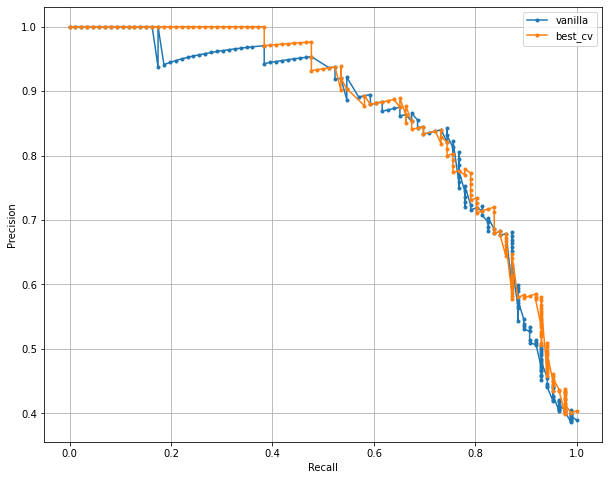

In [8]:
fig, ax = pp.subplots(figsize=(10, 8))
#
for name, curve_dict in PREC_RECALL_DICT.items():
    ax.plot(curve_dict['recall'], curve_dict['precision'], '.-', label=name)
    
ax.legend()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid()